In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [5]:
# Dataset path
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Image dimensions
IMG_SIZE = 256  # You can adjust this based on your GPU memory

# Volume slices to consider
VOLUME_SLICES = 100
VOLUME_START_AT = 22

# Segmentation classes
SEGMENT_CLASSES = {
    0: 'Not Tumor',
    1: 'Necrotic/Core',
    2: 'Edema',
    3: 'Enhancing'
}

In [6]:
# List all case IDs and exclude missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [
    case_id for case_id in all_ids
    if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))
]

# Split the dataset
train_ids, val_ids = train_test_split(
    valid_ids, test_size=0.2, random_state=42
)

print(f"Total cases: {len(valid_ids)}")
print(f"Training cases: {len(train_ids)}")
print(f"Validation cases: {len(val_ids)}")

Total cases: 368
Training cases: 294
Validation cases: 74


In [7]:
class DataGenerator(Sequence):
    def __init__(
        self, list_IDs, dataset_path, batch_size=4, slices_per_patient=5,
        dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True
    ):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size  # Number of patients per batch
        self.slices_per_patient = slices_per_patient  # Number of slices per patient
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        Batch_ids = self.list_IDs[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.list_IDs)

    def __data_generation(self, Batch_ids):
        total_slices = len(Batch_ids) * self.slices_per_patient
        X = np.zeros((total_slices, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((total_slices, *self.dim), dtype=np.uint8)

        count = 0
        for case_id in Batch_ids:
            # Load image and segmentation data
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                continue

            # Load data
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            # Map label 4 to 3 in the entire volume
            seg[seg == 4] = 3
            seg = seg.astype(np.uint8)

            # Find slices that contain tumor regions
            tumor_slices = np.where(np.sum(seg, axis=(0, 1)) > 0)[0]

            if len(tumor_slices) == 0:
                continue  # Skip to the next patient
            else:
                # Randomly select slices that contain tumor
                selected_slices = np.random.choice(tumor_slices, size=self.slices_per_patient, replace=True)

            for j in selected_slices:
                # Process image slices
                flair_slice = cv2.resize(flair[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)
                t1ce_slice = cv2.resize(t1ce[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)

                # Normalize slices
                flair_slice = (flair_slice - np.min(flair_slice)) / (np.max(flair_slice) - np.min(flair_slice) + 1e-8)
                t1ce_slice = (t1ce_slice - np.min(t1ce_slice)) / (np.max(t1ce_slice) - np.min(t1ce_slice) + 1e-8)

                # Stack channels
                X[count, :, :, 0] = flair_slice
                X[count, :, :, 1] = t1ce_slice
                X[count, :, :, 2] = 0.0  # Third channel as zeros

                # Process segmentation mask
                seg_slice = seg[:, :, j]
                seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)

                # Ensure labels are uint8
                seg_resized = seg_resized.astype(np.uint8)

                y[count] = seg_resized
                count += 1

        # One-hot encode segmentation masks
        y_one_hot = tf.one_hot(y, depth=len(SEGMENT_CLASSES), axis=-1)

        return X, y_one_hot

In [8]:
def attention_gate(x, g, inter_channels):
    """
    Attention Gate as proposed in the Attention U-Net paper.

    Args:
        x: Tensor from the encoder pathway (skip connection).
        g: Tensor from the decoder pathway (after upsampling).
        inter_channels: Number of intermediate channels.

    Returns:
        Output tensor after applying the attention mechanism.
    """
    # 1x1 convolution on x and g
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)

    # Combine the features
    add_xg = layers.add([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)

    # Compute attention coefficients
    psi = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)

    # Upsample attention coefficients if necessary
    if x.shape[1] != None and x.shape[2] != None:
        upsample_factor = (x.shape[1] // sigmoid_xg.shape[1], x.shape[2] // sigmoid_xg.shape[2])
    else:
        upsample_factor = (2, 2)  # Default upsampling factor

    upsample_psi = layers.UpSampling2D(size=upsample_factor, interpolation='bilinear')(sigmoid_xg)

    # Multiply attention coefficients with the skip connection
    attn_coefficients = layers.multiply([upsample_psi, x])
    return attn_coefficients

In [9]:
def attention_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(SEGMENT_CLASSES)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder with Attention Gates
    up6 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv5)
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(up6)
    attn6 = attention_gate(conv4, up6, 512)
    merge6 = layers.concatenate([attn6, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv6)
    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(up7)
    attn7 = attention_gate(conv3, up7, 256)
    merge7 = layers.concatenate([attn7, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv7)
    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(up8)
    attn8 = attention_gate(conv2, up8, 128)
    merge8 = layers.concatenate([attn8, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv8)
    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(up9)
    attn9 = attention_gate(conv1, up9, 64)
    merge9 = layers.concatenate([attn9, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output Layer
    conv10 = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)

    return model

In [10]:
# Instantiate the model
model = attention_unet(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=len(SEGMENT_CLASSES)
)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │  2,097,664 │ up_sampling2d[0]

 Total params: 31,731,144 (121.04 MB)

 Trainable params: 31,731,144 (121.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define the custom Dice Loss
def soft_dice_loss(y_true, y_pred, class_weights):
    y_true_f = tf.cast(tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)]), tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)

    dice_score = (2. * intersection + 1e-6) / (denominator + 1e-6)
    dice_loss = 1 - dice_score

    weighted_dice_loss = dice_loss * class_weights
    mean_loss = tf.reduce_mean(weighted_dice_loss)

    return mean_loss

class CustomDiceLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights, name='dice_loss'):
        super(CustomDiceLoss, self).__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)

    def call(self, y_true, y_pred):
        return soft_dice_loss(y_true, y_pred, self.class_weights)

# Define custom Mean IoU metric
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou', dtype=None):
        super(CustomMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super(CustomMeanIoU, self).update_state(y_true, y_pred, sample_weight)

In [12]:
# Define class weights (adjust as necessary)
class_weights = np.array([0.1, 0.3, 0.3, 0.3])

# Instantiate loss and metric
dice_loss = CustomDiceLoss(class_weights=class_weights)
custom_mean_iou = CustomMeanIoU(num_classes=len(SEGMENT_CLASSES), name='mean_iou')

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', custom_mean_iou]
)

In [13]:
# Initialize data generators
training_generator = DataGenerator(
    train_ids,
    TRAIN_DATASET_PATH,
    batch_size=4,
    slices_per_patient=5,
    shuffle=True
)
validation_generator = DataGenerator(
    val_ids,
    TRAIN_DATASET_PATH,
    batch_size=4,
    slices_per_patient=5,
    shuffle=False
)

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('attention_unet_best_model.keras', monitor='val_loss', save_best_only=True),
    CSVLogger('attention_unet_training.log', separator=',', append=False)
]

In [15]:
# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks,
    verbose=1  # Set to 1 for progress bar, 2 for one line per epoch, 0 for silent
)

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731692656.014876     662 service.cc:145] XLA service 0x7c92f0002cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731692656.014985     662 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731692709.977354     662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9107 - loss: 0.2286 - mean_iou: 0.2204 - val_accuracy: 0.9767 - val_loss: 0.2253 - val_mean_iou: 0.2418 - learning_rate: 0.0010
Epoch 2/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 74s 946ms/step - accuracy: 0.9750 - loss: 0.2253 - mean_iou: 0.2327 - val_accuracy: 0.9759 - val_loss: 0.2253 - val_mean_iou: 0.2416 - learning_rate: 0.0010
Epoch 3/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9761 - loss: 0.2253 - mean_iou: 0.2336
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
74/74 ━━━━━━━━━━━━━━━━━━━━ 74s 943ms/step - accuracy: 0.9761 - loss: 0.2253 - mean_iou: 0.2335 - val_accuracy: 0.9760 - val_loss: 0.2253 - val_mean_iou: 0.2416 - learning_rate: 0.0010
Epoch 4/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 74s 945ms/step - accuracy: 0.9762 - loss: 0.2253 - mean_iou: 0.2330 - val_accuracy: 0.9755 - val_loss: 0.2253 - val_mean_iou: 0.2415 - learning_rate: 2.0000e-04
Epoch 5/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accu

In [16]:
# Load the best model weights
model.load_weights('attention_unet_best_model.keras')

# Evaluate on the validation set
val_loss, val_accuracy, val_mean_iou = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Mean IoU: {val_mean_iou:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step - accuracy: 0.9766 - loss: 0.2253 - mean_iou: 0.2436
Validation Loss: 0.2253
Validation Accuracy: 0.9770
Validation Mean IoU: 0.2420


In [18]:
def combined_loss(y_true, y_pred):
    # Dice Loss
    y_true_f = tf.cast(tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)]), tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice_loss = 1 - (2. * intersection + 1e-6) / (denominator + 1e-6)
    dice_loss = tf.reduce_mean(dice_loss)

    # Categorical Cross-Entropy Loss
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    ce_loss = tf.reduce_mean(ce_loss)

    # Combined Loss
    total_loss = ce_loss + dice_loss
    return total_loss

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=combined_loss,
    metrics=['accuracy', custom_mean_iou]
)

In [22]:
# Collect pixel counts for each class
class_counts = np.zeros(len(SEGMENT_CLASSES))

for case_id in train_ids:
    seg_path = os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii")
    seg = nib.load(seg_path).get_fdata()
    seg[seg == 4] = 3  # Map label 4 to 3
    counts = np.bincount(seg.flatten().astype(int), minlength=len(SEGMENT_CLASSES))
    class_counts += counts

total_pixels = np.sum(class_counts)
class_weights = total_pixels / (len(SEGMENT_CLASSES) * class_counts)
class_weights = class_weights / np.sum(class_weights)  # Normalize

print("Class Weights:", class_weights)

Class Weights: [0.0010058  0.40599282 0.1491477  0.44385368]


In [25]:
total_weight = np.sum(class_weights)
normalized_class_weights = class_weights / total_weight
print("Normalized Class Weights:", normalized_class_weights)

Normalized Class Weights: [0.0010058  0.40599282 0.1491477  0.44385368]


In [26]:
min_weight = 0.05
max_weight = 0.9

adjusted_class_weights = np.clip(normalized_class_weights, min_weight, max_weight)
adjusted_class_weights /= np.sum(adjusted_class_weights)  # Re-normalize

print("Adjusted Class Weights:", adjusted_class_weights)

Adjusted Class Weights: [0.04766471 0.38703057 0.14218163 0.4231231 ]


In [31]:
def weighted_categorical_crossentropy(y_true, y_pred, weights):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute the categorical cross-entropy loss without reduction
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)

    # Multiply by class weights
    weights = tf.reduce_sum(weights * y_true, axis=-1)
    weighted_cce = cce * weights

    return tf.reduce_mean(weighted_cce)

In [33]:
# Ensure adjusted_class_weights is a numpy array
adjusted_class_weights = np.array(adjusted_class_weights, dtype=np.float32)

# Convert to TensorFlow constant
class_weights_tf = tf.constant(adjusted_class_weights)

In [35]:
def custom_loss(y_true, y_pred):
    return weighted_categorical_crossentropy(y_true, y_pred, class_weights_tf)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=custom_loss,
    metrics=['accuracy', custom_mean_iou]
)

In [36]:
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

Epoch 1/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7645 - loss: 1987901184.0000 - mean_iou: 0.1698 - val_accuracy: 0.9777 - val_loss: 0.0149 - val_mean_iou: 0.2422 - learning_rate: 0.0010
Epoch 2/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 73s 936ms/step - accuracy: 0.9736 - loss: 0.0175 - mean_iou: 0.2589 - val_accuracy: 0.9524 - val_loss: 0.0151 - val_mean_iou: 0.3154 - learning_rate: 0.0010
Epoch 3/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 75s 956ms/step - accuracy: 0.9702 - loss: 0.0144 - mean_iou: 0.3084 - val_accuracy: 0.9657 - val_loss: 0.0135 - val_mean_iou: 0.3217 - learning_rate: 0.0010
Epoch 4/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 956ms/step - accuracy: 0.9708 - loss: 0.0138 - mean_iou: 0.3354 - val_accuracy: 0.9559 - val_loss: 0.0134 - val_mean_iou: 0.3040 - learning_rate: 0.0010
Epoch 5/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 75s 956ms/step - accuracy: 0.9712 - loss: 0.0137 - mean_iou: 0.3436 - val_accuracy: 0.9697 - val_loss: 0.0126 - val_mean_iou: 0.3055 - learning_rate: 0.0010
Epoch 6/35
74/74 ━━

In [38]:
# Compile the model without class weights
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', custom_mean_iou]
)

In [40]:
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)])
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    
    dice_loss = 1 - (2. * intersection + 1e-7) / (denominator + 1e-7)
    dice_loss = tf.reduce_mean(dice_loss)
    return dice_loss

In [41]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,  # Use the simplified dice loss without class weights
    metrics=['accuracy', custom_mean_iou]
)

In [43]:
# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', custom_mean_iou]
)

In [44]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

In [45]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss,
    metrics=['accuracy', custom_mean_iou]
)

In [46]:
# Begin training
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,  # You can adjust the number of epochs as needed
    callbacks=callbacks,
    verbose=1  # Set to 1 to see progress bars during training
)


Epoch 1/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9713 - loss: 0.0127 - mean_iou: 0.2902 - val_accuracy: 0.9767 - val_loss: 0.0097 - val_mean_iou: 0.2778 - learning_rate: 0.0010
Epoch 2/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9764 - loss: 0.0095 - mean_iou: 0.2856 - val_accuracy: 0.9797 - val_loss: 0.0087 - val_mean_iou: 0.2925 - learning_rate: 0.0010
Epoch 3/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 965ms/step - accuracy: 0.9766 - loss: 0.0096 - mean_iou: 0.2902 - val_accuracy: 0.9803 - val_loss: 0.0083 - val_mean_iou: 0.3136 - learning_rate: 0.0010
Epoch 4/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9774 - loss: 0.0089 - mean_iou: 0.2848 - val_accuracy: 0.9786 - val_loss: 0.0090 - val_mean_iou: 0.3209 - learning_rate: 0.0010
Epoch 5/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.9760 - loss: 0.0096 - mean_iou: 0.3001
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
74/74 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accur

In [48]:
# Load the best model weights
model.load_weights('attention_unet_best_model.keras')

# Evaluate on the validation set
val_loss, val_accuracy, val_mean_iou = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Mean IoU: {val_mean_iou:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 711ms/step - accuracy: 0.9805 - loss: 0.0078 - mean_iou: 0.3244
Validation Loss: 0.0081
Validation Accuracy: 0.9800
Validation Mean IoU: 0.3195


In [28]:
class_frequencies = class_counts / total_pixels
median_frequency = np.median(class_frequencies)
class_weights_mfb = median_frequency / class_frequencies
class_weights_mfb /= np.sum(class_weights_mfb)  # Normalize

print("Median Frequency Balanced Class Weights:", class_weights_mfb)

Median Frequency Balanced Class Weights: [0.0010058  0.40599282 0.1491477  0.44385368]


In [27]:
log_class_weights = np.log1p(class_weights)
normalized_log_weights = log_class_weights / np.sum(log_class_weights)
print("Log-Scaled Class Weights:", normalized_log_weights)

Log-Scaled Class Weights: [0.00118536 0.40178001 0.16392284 0.43311178]


In [ ]:
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

In [47]:
def compute_dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)])
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice_score = (2. * intersection + 1e-6) / (denominator + 1e-6)
    return dice_score.numpy()

# Get predictions on the validation set
y_true_list = []
y_pred_list = []

for X_batch, y_batch in validation_generator:
    y_pred_batch = model.predict(X_batch)
    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

    if len(y_true_list) >= len(validation_generator):
        break

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Compute Dice coefficient
dice_coeff = compute_dice_coefficient(y_true, y_pred)
print("Dice Coefficient per class:")
for i, class_name in SEGMENT_CLASSES.items():
    print(f"Class {i} ({class_name}): {dice_coeff[i]:.4f}")
print(f"Mean Dice Coefficient: {np.mean(dice_coeff):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Dice Coefficient per class:
Class 0 (Not Tumor): 0.9679
Class 1 (Necrotic/Core): 0.0831
Class 2 (Edema): 0.1630
Class 3 (Enhancing): 0.0704
Mean Dice Coefficient: 0.3211


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


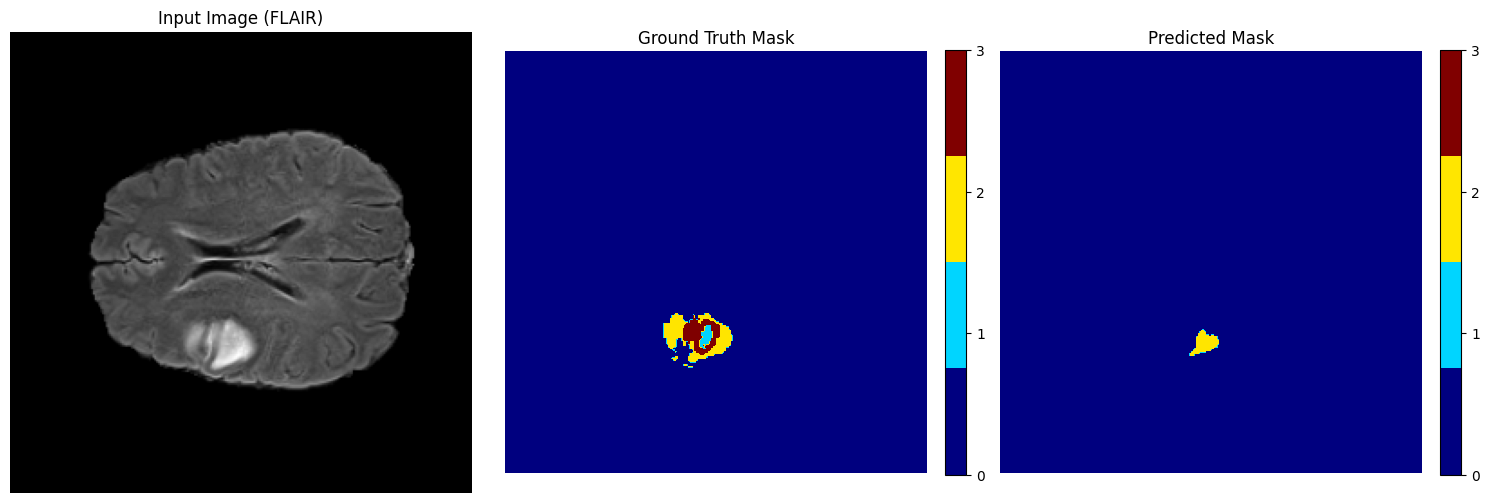

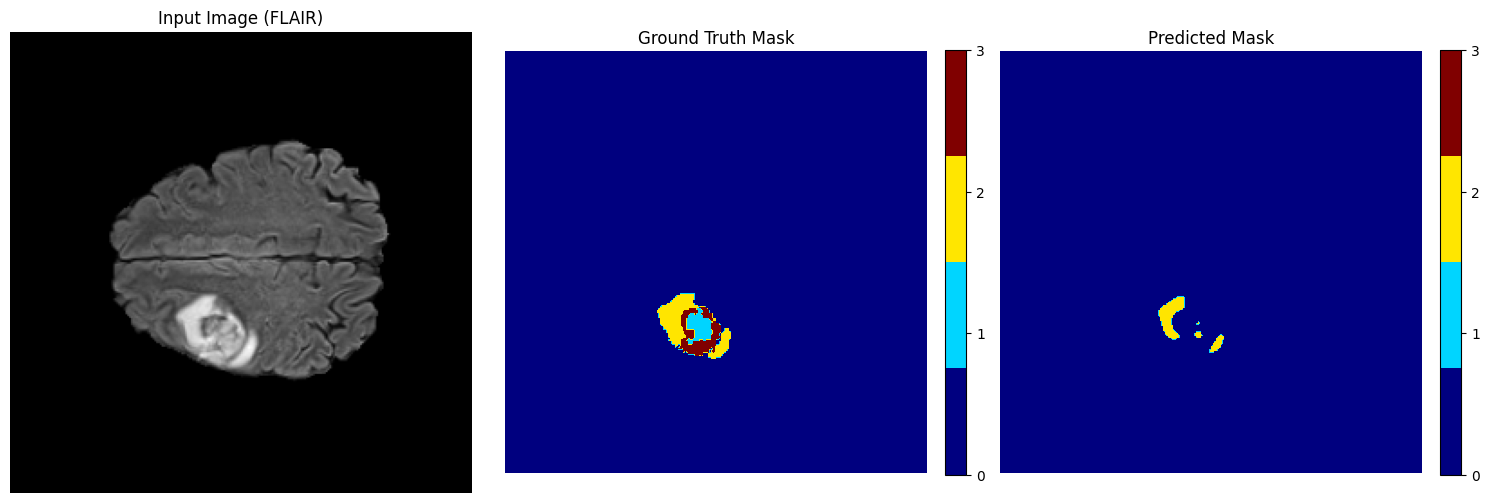

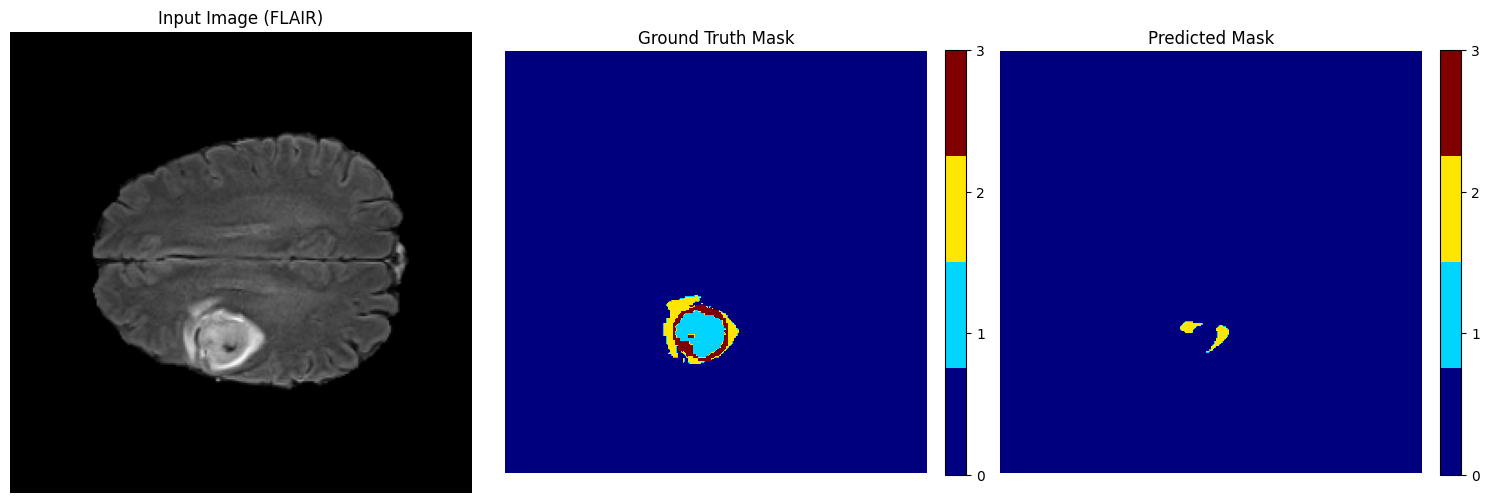

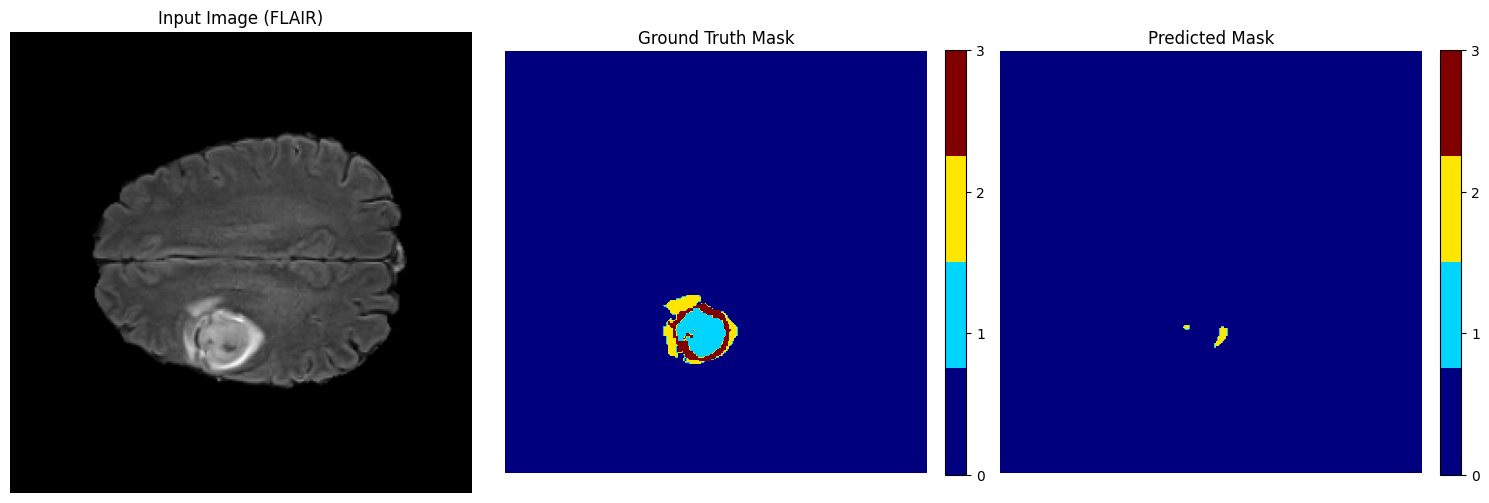

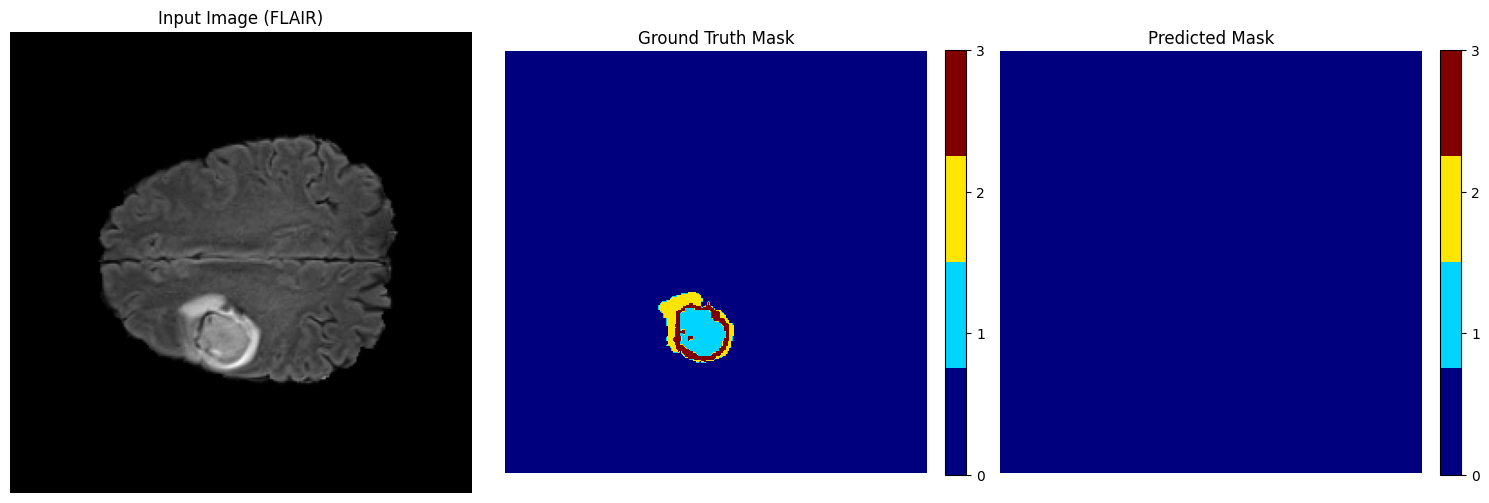

In [49]:
def visualize_predictions(model, data_generator, num_images=5, save_dir='images'):
    import os
    import matplotlib.pyplot as plt

    # Create 'images' directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Set the color map for segmentation classes
    cmap = plt.get_cmap('jet', len(SEGMENT_CLASSES))

    for X_batch, y_true_batch in data_generator:
        y_pred_batch = model.predict(X_batch)
        y_pred_argmax = np.argmax(y_pred_batch, axis=-1)
        y_true_argmax = np.argmax(y_true_batch, axis=-1)

        for i in range(num_images):
            plt.figure(figsize=(15, 5))

            # Original Image (FLAIR)
            plt.subplot(1, 3, 1)
            plt.imshow(X_batch[i, :, :, 0], cmap='gray')
            plt.title('Input Image (FLAIR)')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(y_true_argmax[i], cmap=cmap, vmin=0, vmax=len(SEGMENT_CLASSES)-1)
            plt.title('Ground Truth Mask')
            plt.colorbar(ticks=range(len(SEGMENT_CLASSES)), fraction=0.046, pad=0.04)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred_argmax[i], cmap=cmap, vmin=0, vmax=len(SEGMENT_CLASSES)-1)
            plt.title('Predicted Mask')
            plt.colorbar(ticks=range(len(SEGMENT_CLASSES)), fraction=0.046, pad=0.04)
            plt.axis('off')

            plt.tight_layout()
            # Save the figure
            plt.savefig(f"{save_dir}/attention_unet_sample_{i+1}.png")
            plt.show()

        # Break after visualizing the desired number of images
        break

# Call the visualization function
visualize_predictions(model, validation_generator, num_images=5)

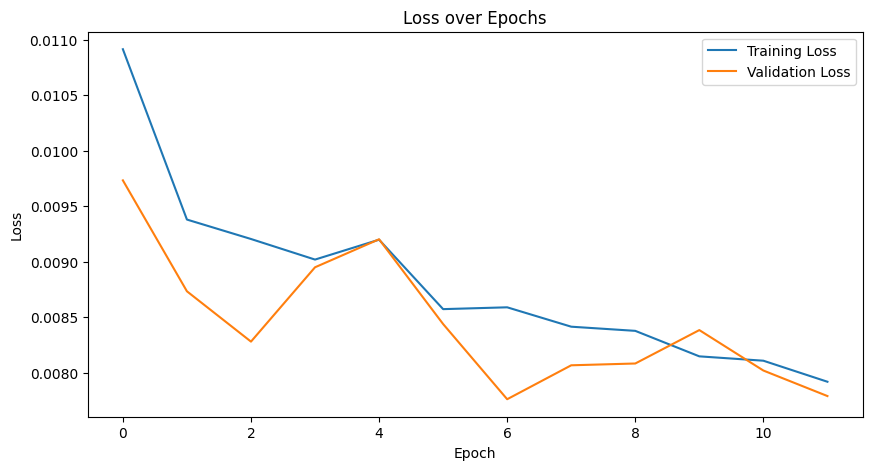

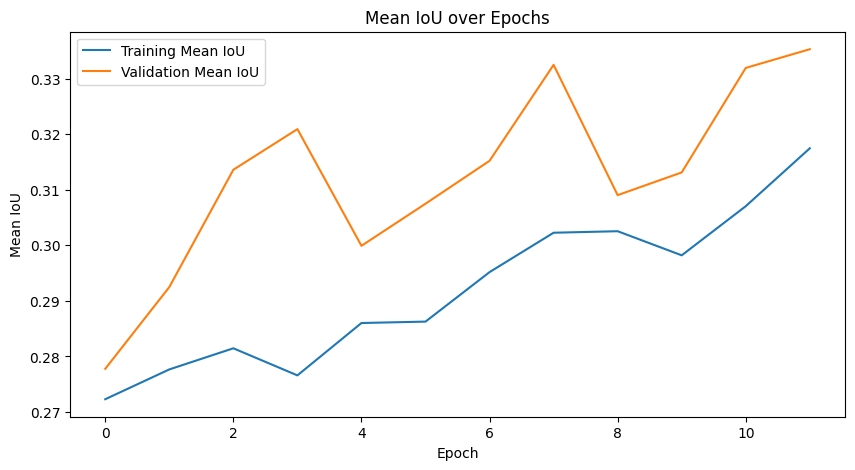

In [50]:
# Create 'images' directory if it doesn't exist
import os
os.makedirs('images', exist_ok=True)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/attention_unet_loss_plot.png')
plt.show()

# Plot Training and Validation Mean IoU
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.title('Mean IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()
plt.savefig('images/attention_unet_mean_iou_plot.png')
plt.show()

In [51]:
# Save the entire model
model.save('attention_unet_model.keras')